# Extracting object from background

In [2]:
import matplotlib.pyplot as plt
from commonfunctions import *
from skimage.morphology import erosion, dilation, opening, closing
from skimage.filters import median
from skimage.filters import gaussian
from skimage.filters import threshold_otsu

In [3]:
def get_threshold(img):
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    plt.plot(hist)
    plt.show()

    first_max = np.argmax(hist)
    if first_max-80 > 0:
        second_max = np.argmax(hist[0:first_max-80])
        if (len(hist[second_max:first_max]) == 0):
            return 0
    
        threshold_min = np.argmin(hist[second_max:first_max]) + second_max
    elif first_max+80 < 255:
        second_max = np.argmax(hist[first_max+80:255]) + first_max+80
        if (len(hist[first_max:second_max]) == 0):
            return 0
        
        threshold_min = np.argmin(hist[first_max:second_max]) + first_max
    else:
        return 0

    print("first_max = ", hist[first_max])
    print("second_max = ", hist[second_max])
    print("threshold_min = ", hist[threshold_min])
    if hist[first_max] > hist[threshold_min]+100 and hist[second_max] > hist[threshold_min]+100:
        return threshold_min
    else:
        return 0

In [4]:
def background(img, threshold_R, threshold_G, threshold_B):
    guess = 0
    if np.all(img[0,0] > [threshold_R, threshold_G, threshold_B]):
        guess += 1
    if np.all(img[0,len(img[0])-1] > [threshold_R, threshold_G, threshold_B]):
        guess += 1
    if np.all(img[len(img)-1,0] > [threshold_R, threshold_G, threshold_B]):
        guess += 1
    if np.all(img[len(img)-1,len(img[0])-1] > [threshold_R, threshold_G, threshold_B]):
        guess += 1
    
    if guess > 2:
        return True
    else:
        return False


In [5]:
def histogram_Equalization(img):
    hist = np.histogram(img, bins=256)[0]
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    new_img = np.interp(img, np.arange(0, 1, 1/256), cdf)
    return new_img
    

In [6]:
def noise_removal(img):
    img = median(img)
    # img = gaussian(img, sigma=1)
    return img

In [17]:
def fix_fill(img, mask):

    mask = mask.astype(np.uint8)
    #Noise removal
    noise_removal_mask = noise_removal(mask)
    
    #fix mask
    SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (min(20, int(img.shape[0]*.03)), min(20, int(img.shape[1]*.03))))
    closed_mask = closing(noise_removal_mask, SE)

    # Find contours in the mask
    contours, hierarchy = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_contour_area = 2000

    # Filter out tiny contours
    significant_contours = [contour for contour in contours if cv2.contourArea(contour) >= min_contour_area]

    # Create an empty mask to draw filled contours
    filled_mask = np.zeros_like(closed_mask)

    # Draw filled contours on the new mask
    cv2.drawContours(filled_mask, significant_contours, -1, 1, cv2.FILLED)
    return filled_mask

In [18]:
def adaptive_thresholding(img):
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Apply adaptive thresholding to the V channel
    v_channel = hsv_image[:, :, 2]
    thresh = cv2.adaptiveThreshold(v_channel, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    # Use the threshold to create a mask
    mask = cv2.inRange(hsv_image, (0, 0, 0), (180, 255, thresh))

    # Apply the mask to the original img for color segmentation
    result = cv2.bitwise_and(img, img, mask=mask)
    return result

In [19]:
def segment_background(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2] 

    #Step3: Apply median filter.
    median_img = median(img[:,:,2])

    #Step4: Histogram.
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    plt.plot(hist)
    plt.show()

    # hist[210:255].sum() > hist[0:255].sum()*0.5
    if (False):
        print("Background")
        # mask = np.all(img < [200, 200, 200], axis=2)
        # threshold_img = np.zeros_like(img)
        # threshold_img[mask] = img[mask]
        # show_images([img, threshold_img], ["Original", "Thresholded"])
    else:
        threshold_R = get_threshold(img[:,:,0])
        threshold_G = get_threshold(img[:,:,1])
        threshold_B = get_threshold(img[:,:,2])
        print("threshold_R = ", threshold_R)
        print("threshold_G = ", threshold_G)
        print("threshold_B = ", threshold_B)

        # threshold_R = threshold_otsu(img[:,:,0])
        # threshold_G = threshold_otsu(img[:,:,1])
        # threshold_B = threshold_otsu(img[:,:,2])
        # print("threshold_R = ", threshold_R)
        # print("threshold_G = ", threshold_G)
        # print("threshold_B = ", threshold_B)
        
        #Step5: Thresholding.
        if background(img, threshold_R, threshold_G, threshold_B):
            if (threshold_R == 0):
                threshold_R = 255
            if (threshold_G == 0):
                threshold_G = 255
            if (threshold_B == 0):
                threshold_B = 255
            mask = np.all(img < [threshold_R, threshold_G, threshold_B], axis=2)
        else:
            mask = np.all(img > [threshold_R, threshold_G, threshold_B], axis=2)

    return mask


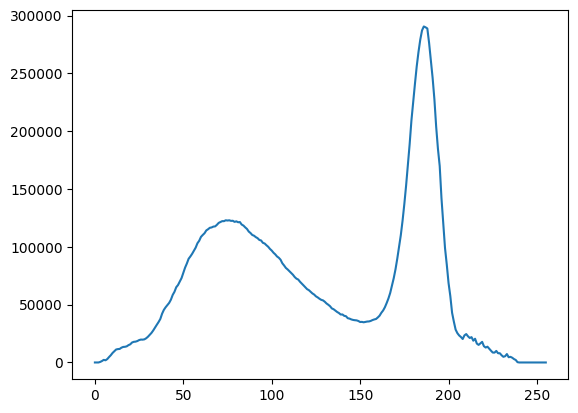

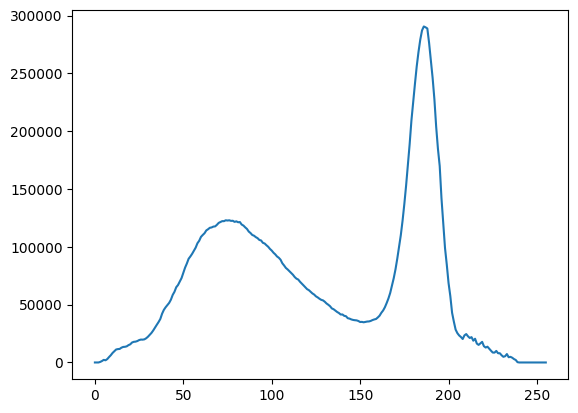

first_max =  [290541.]
second_max =  [122952.]
threshold_min =  [34753.]


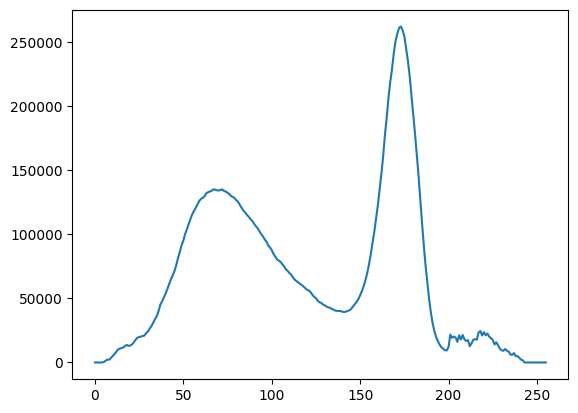

first_max =  [262270.]
second_max =  [135102.]
threshold_min =  [39345.]


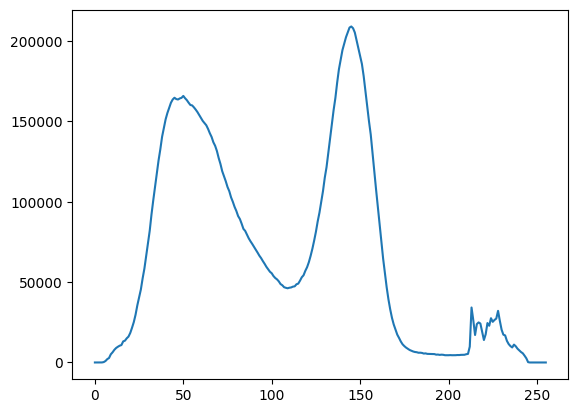

first_max =  [209104.]
second_max =  [165882.]
threshold_min =  [46187.]
threshold_R =  152
threshold_G =  141
threshold_B =  109


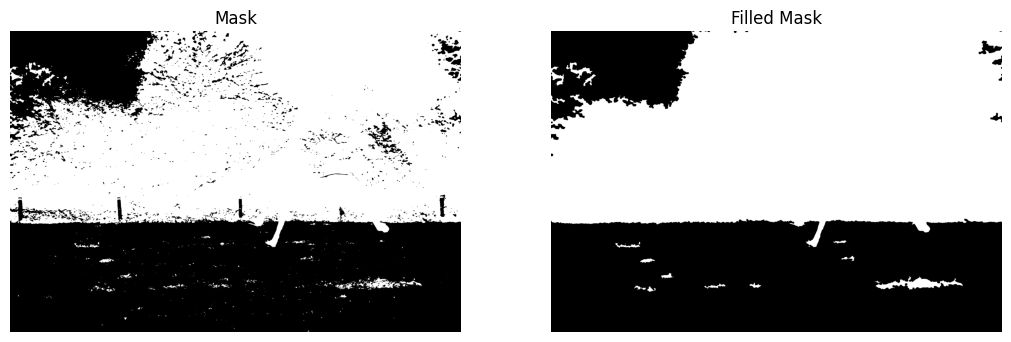

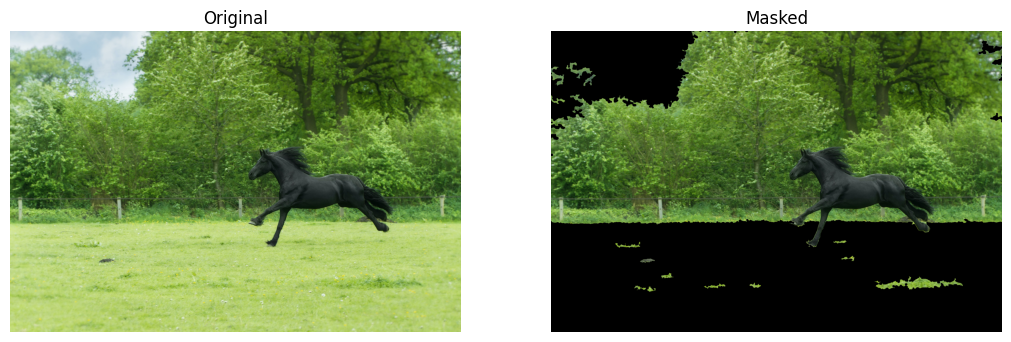

In [26]:
img = io.imread('./Test_Images/horse.jpg').astype(np.uint8)
img_filtered = gaussian(img, sigma=1.1)
# print(img)
# print(img_filtered)

mask = segment_background((img_filtered*255).astype(np.uint8))
filled_mask = fix_fill(img, mask)

show_images([mask, filled_mask], ["Mask", "Filled Mask"])
show_images([img, img*filled_mask[:,:,None]], ["Original", "Masked"])


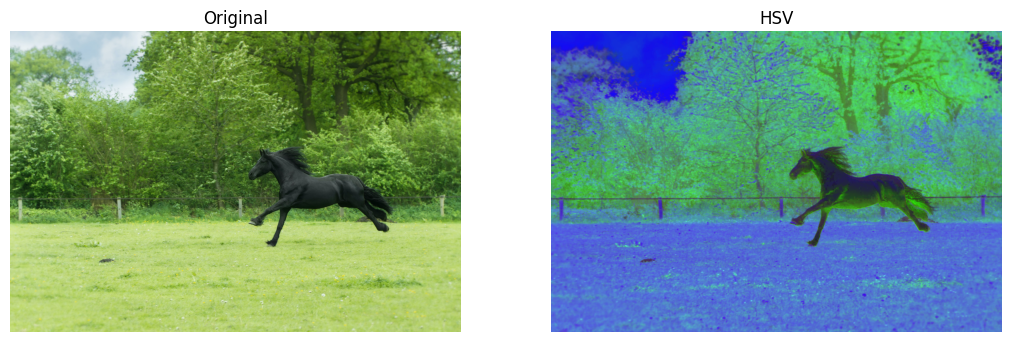

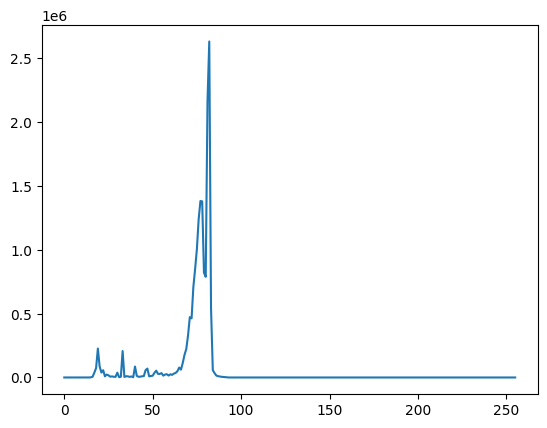

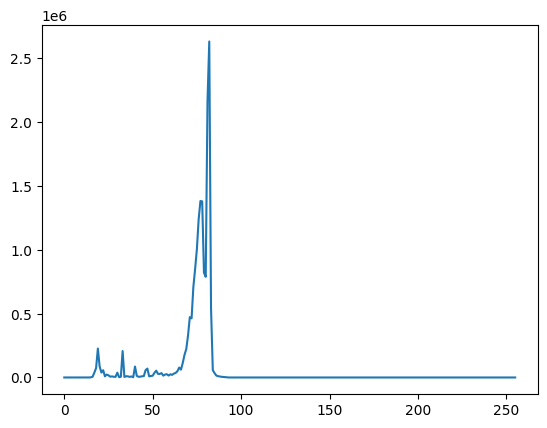

first_max =  [2632477.]
second_max =  [6.]
threshold_min =  [0.]


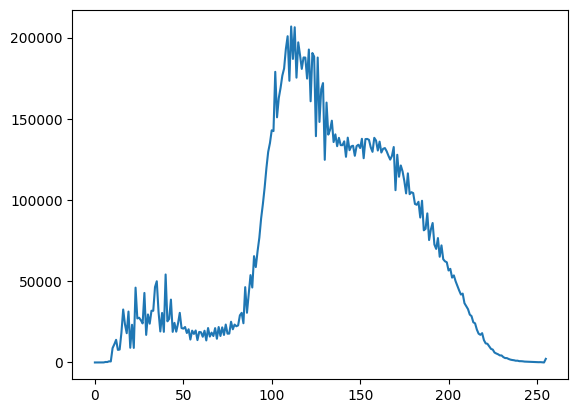

first_max =  [206856.]
second_max =  [46073.]
threshold_min =  [13587.]


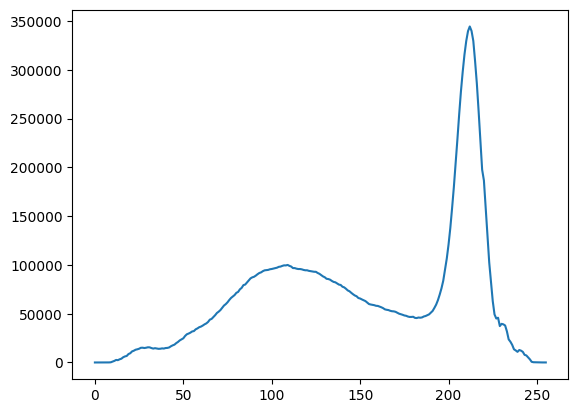

first_max =  [344436.]
second_max =  [99992.]
threshold_min =  [45547.]
threshold_R =  0
threshold_G =  63
threshold_B =  182


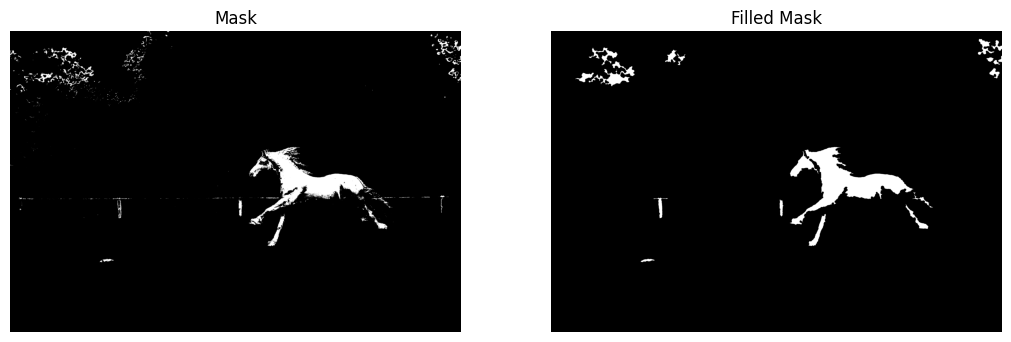

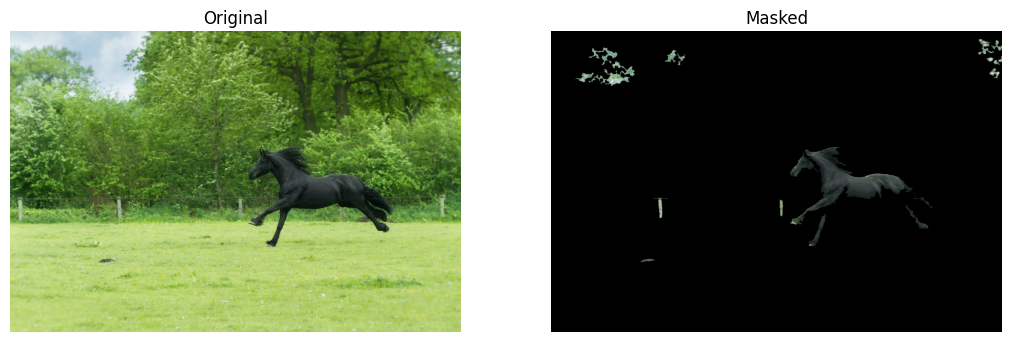

In [27]:
hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
show_images([img, hsv_image], ["Original", "HSV"])

mask = segment_background(hsv_image)
filled_mask = fix_fill(hsv_image, mask)

show_images([mask, filled_mask], ["Mask", "Filled Mask"])
show_images([img, img*filled_mask[:,:,None]], ["Original", "Masked"])
